# scRNA-Seq dataset [Candeli et al. (2025)](https://www....)

Single cell transcriptome analysis of NEr-fAOs

Show that while enriched for PNECs, NEr-fAOs retain diverse airway cell types, preserving epithelial complexity. We map PNEC trajectories in NEr-fAOs, uncovering precursor and mature states. Comparative analyses show that basal stem cells in NEr-fAOs acquire lower airway progenitor (LAP)-like signatures.

## Imports

In [5]:
import scvelo as scv
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import os, tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import csv
from gtfparse import read_gtf
import hdf5plugin
import seaborn as sns
import scanpy.external as sce
from scipy.sparse import coo_matrix
import scipy
from scipy import sparse
from bioinfokit import analys, visuz
from sanbomics.plots import volcano
from adjustText import adjust_text
import leidenalg
import gseapy
import decoupler
from scipy import io
import anndata as ad
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib as mpl
from scipy.sparse import csr_matrix
import harmonypy as hm

## Figure Settings

In [2]:
# Set font types to ensure text is editable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42   # For PDF export
mpl.rcParams['ps.fonttype'] = 42    # For PS export
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.dpi'] = 600

# Scanpy figure settings
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, 
                     frameon=False, vector_friendly=True, fontsize=12, 
                     figsize=(5,4), color_map=None, format='pdf', facecolor=None, 
                     transparent=False, ipython_format='png')

# scVelo figure settings
scv.set_figure_params(style='scvelo', dpi=80, dpi_save=600, 
                      frameon=False, vector_friendly=True, transparent=True, fontsize=12, 
                      figsize=(5,4), color_map=None, facecolor=None, format='pdf', ipython_format='png')

# Set figure directory
sc.settings.figdir = './figures/'
scv.settings.figdir = './figures/'

figfolder = './figures/'

# Fine-tune Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['figure.subplot.wspace'] = 0.99
plt.rcParams['axes.grid'] = False

import logging
# Suppress INFO messages
logging.getLogger("fontTools").setLevel(logging.WARNING)
plt.set_loglevel('WARNING') 

## Custom colormap

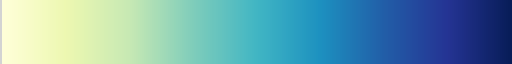

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define the 'lightgrey' color as an RGBA tuple with values in the range 0-1
lightgrey_rgba = (0.83, 0.83, 0.83, 1.0)  # RGB values for lightgrey with alpha=1.0
# Get the 'YlGnBu' colormap
YlGnBu_cmap = plt.cm.get_cmap('YlGnBu')
# Define the number of steps for interpolation
num_steps = 256
# Define the range for values where lightgrey is used
lightgrey_range = 0.0
# Interpolate between light grey and blue for values from 0 to lightgrey_range
interpolated_colors_below = [lightgrey_rgba] + [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * lightgrey_range))]
# Interpolate between light grey and green for values from lightgrey_range to 1
interpolated_colors_above = [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * (1 - lightgrey_range)))]
# Combine the two sets of colors
interpolated_colors = interpolated_colors_below + interpolated_colors_above
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_YlGnBu', interpolated_colors)
# Now you can use this custom colormap in your plots
cmap

## Inspect matrixes AnnData

In [4]:
import numpy as np
from scipy.sparse import issparse

def matrix_summary(adata):
    """
    Prints min, max, and mean for expression matrix, counts layer, raw matrix,
    and scaled layer of an AnnData object.

    Parameters:
        adata: AnnData
    """

    # Helper function to compute min, max, mean
    def summary(matrix, name):
        if issparse(matrix):
            matrix = matrix.toarray()
        flat = matrix.flatten()
        mean_value = flat.mean()
        print(f"{name}: min={flat.min()}, max={flat.max()}, mean={mean_value}")

    # Expression matrix
    summary(adata.X, "Expression matrix (X)")

    # Counts layer
    if 'counts' in adata.layers:
        summary(adata.layers['counts'], "Counts layer matrix (layers['counts'])")
    else:
        print("Counts layer not found in adata.layers.")

    # Raw matrix
    if adata.raw is not None:
        summary(adata.raw.X, "Raw matrix (raw.X)")
    else:
        print("Raw matrix not found in adata.raw.")

    # Scaled layer
    if 'scaled' in adata.layers:
        summary(adata.layers['scaled'], "Scaled layer matrix (layers['scaled'])")
    else:
        print("Scaled layer not found in adata.layers.")

# Subset Neuroendocrine cells

In [5]:
#Load adata
adata=sc.read_h5ad('./data/NEr_fAOs_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'CELLTYPIST', 'PNEC_Signature', 'CELLTYPIST_media', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CELLTYPIST_colors', 'CELLTYPIST_media_colors', 'CE

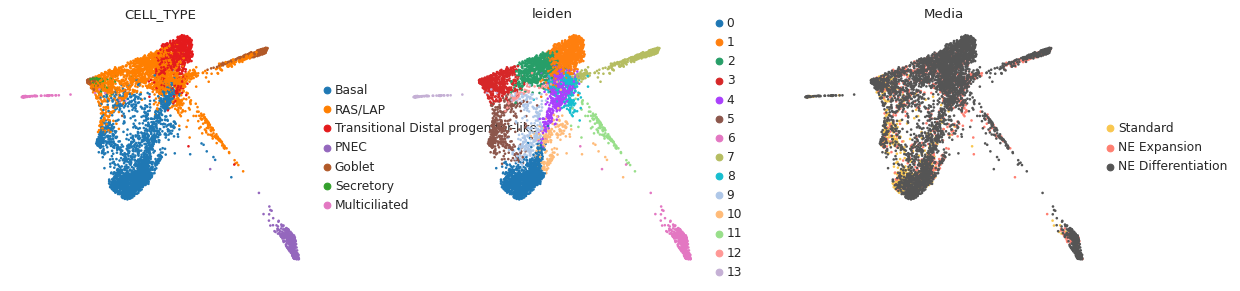

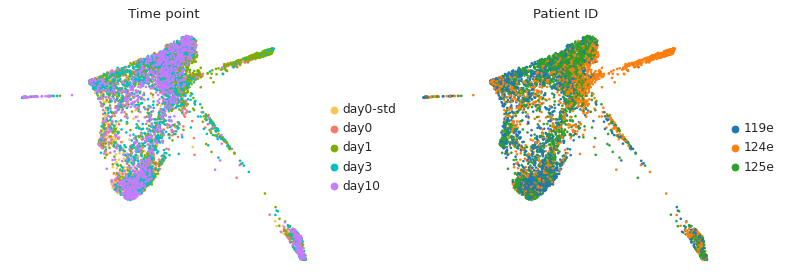

In [77]:
sc.pl.draw_graph(adata,use_raw=True, color=['CELL_TYPE','leiden','Media'])
sc.pl.draw_graph(adata,use_raw=True, color=['Time point','Patient ID'])

In [78]:
column_0 = adata.obs['CELL_TYPE']
column_1 = adata.obs['leiden']
column_2 = adata.obs['Media']
# Create a DataFrame using the extracted columns
df = pd.DataFrame({'Cell type': column_0,
                   'leiden': column_1,
                   'Media': column_2,})
df

,Cell type,leiden,Media
s003.1,Basal,5,Standard
s003.2,Multiciliated,13,Standard
s003.3,Basal,5,Standard
s003.4,Basal,0,Standard
s003.5,Basal,0,Standard
...,...,...,...
s007.152,Basal,0,NE Differentiation
s007.154,RAS/LAP,2,NE Differentiation
s007.155,RAS/LAP,2,NE Differentiation
s007.156,Basal,0,NE Differentiation


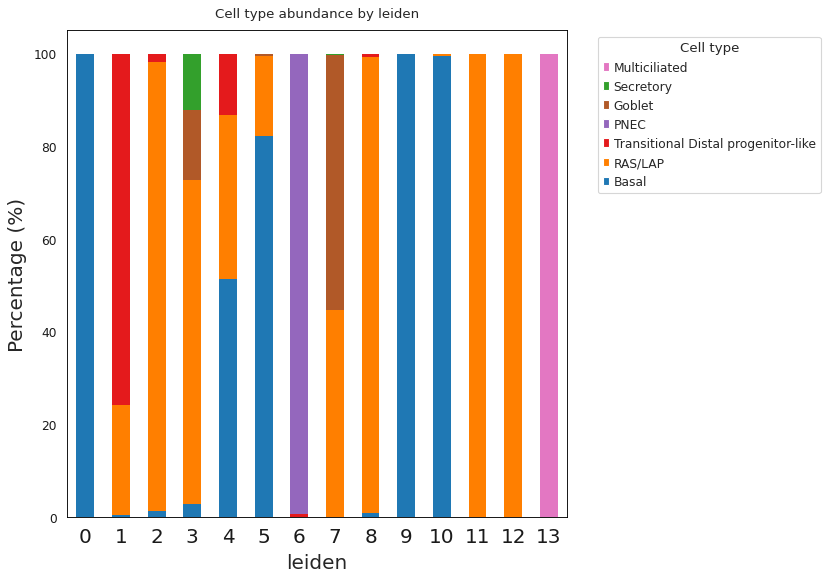

In [80]:
## Figure 1E

fig, ax = plt.subplots(figsize=(8, 8))

# Group by and calculate the percentage of each category
grouped_df = df.groupby('leiden')['Cell type'].value_counts(normalize=True).unstack(fill_value=0) * 100
grouped_df = grouped_df.reset_index().set_index('leiden')
#order = ['Standard','NE Expansion','NE Differentiation']
#grouped_df = grouped_df.loc[order]

# Plot the bar chart
ax = grouped_df.plot(kind='bar', stacked=True, alpha=1,color=adata.uns['CELL_TYPE_colors'],ax=ax)

# Customize the plot
plt.title('Cell type abundance by leiden',pad=12)
plt.xlabel('leiden',size=18, labelpad=6)
plt.ylabel('Percentage (%)', size=18,labelpad=6)
plt.xticks(rotation=0,size=18)
ax.set_xticklabels([label.replace(' ', '\n') for label in grouped_df.index], size=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Force each patch to have no edge
for patch in ax.patches:
    patch.set_edgecolor('none')
    
plt.savefig(os.path.join(figfolder,'StackedPlot_fAOs_leiden_celltype'),
            bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

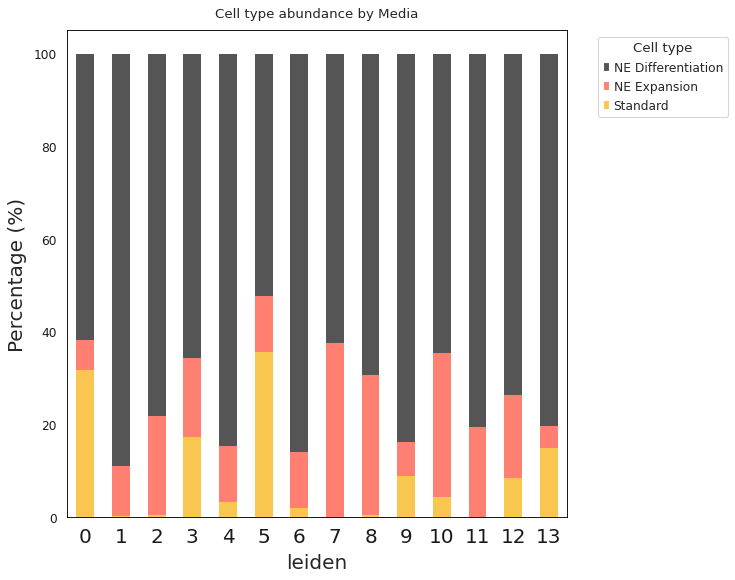

In [81]:
## Figure 1E

fig, ax = plt.subplots(figsize=(8, 8))

# Group by and calculate the percentage of each category
grouped_df = df.groupby('leiden')['Media'].value_counts(normalize=True).unstack(fill_value=0) * 100
grouped_df = grouped_df.reset_index().set_index('leiden')
#order = ['Standard','NE Expansion','NE Differentiation']
#grouped_df = grouped_df.loc[order]

# Plot the bar chart
ax = grouped_df.plot(kind='bar', stacked=True, alpha=1,color=adata.uns['Media_colors'],ax=ax)

# Customize the plot
plt.title('Cell type abundance by Media',pad=12)
plt.xlabel('leiden',size=18, labelpad=6)
plt.ylabel('Percentage (%)', size=18,labelpad=6)
plt.xticks(rotation=0,size=18)
ax.set_xticklabels([label.replace(' ', '\n') for label in grouped_df.index], size=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Force each patch to have no edge
for patch in ax.patches:
    patch.set_edgecolor('none')

plt.savefig(os.path.join(figfolder,'StackedPlot_fAOs_leiden_media'),
            bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

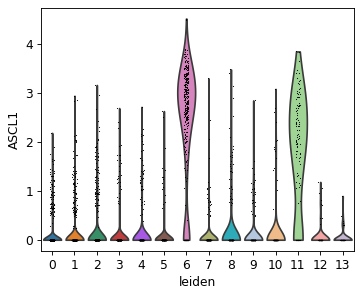

In [242]:
sc.pl.violin(adata, 'ASCL1',use_raw=True, groupby='leiden', save='_Std_NE_Exp_Diff_leiden_ASCL1')

In [243]:
# Create a boolean mask based on your condition
condition_mask = (
    adata.obs['leiden'].isin(['6','11']) &
    adata.obs['Media'].isin(['NE Expansion', 'NE Differentiation'])
)

adata_NE = adata[condition_mask]
cells_ID = adata_NE.obs_names

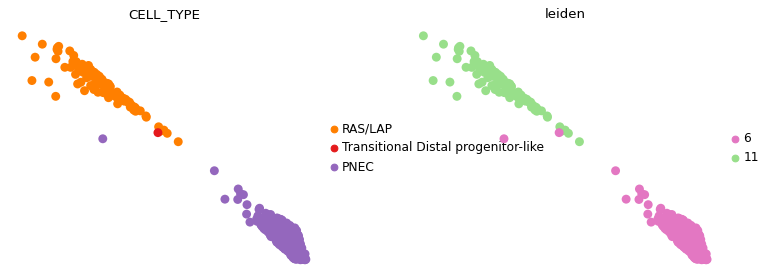

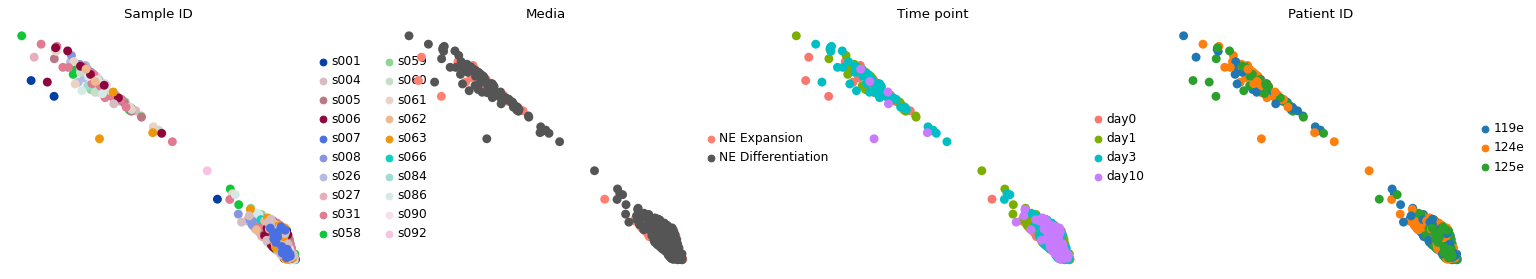

In [244]:
sc.pl.draw_graph(adata_NE,use_raw=True, color=['CELL_TYPE','leiden'])
sc.pl.draw_graph(adata_NE,use_raw=True, color=['Sample ID','Media','Time point','Patient ID'])

In [245]:
adata=sc.read_h5ad('./data/STARsolo.velocyto_NEr-fAOs.h5ad')
adata

AnnData object with n_obs × n_vars = 5817 × 32245
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [246]:
condition_mask = adata.obs_names.isin(cells_ID)
adata = adata[condition_mask]
adata

View of AnnData object with n_obs × n_vars = 466 × 32245
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [247]:
sample_ids = adata.obs['Sample ID'].unique()
print(sample_ids)

['s027', 's026', 's001', 's058', 's059', ..., 's062', 's063', 's090', 's004', 's007']
Length: 20
Categories (20, object): ['s001', 's004', 's005', 's006', ..., 's084', 's086', 's090', 's092']


In [248]:
media_ids = adata.obs['Media'].unique()
print(media_ids)

['NE Expansion', 'NE Differentiation']
Categories (2, object): ['NE Differentiation', 'NE Expansion']


In [249]:
time_ids = adata.obs['Time point'].unique()
print(time_ids)

['day0', 'day1', 'day3', 'day10']
Categories (4, object): ['day0', 'day1', 'day3', 'day10']


In [250]:
patient_ids = adata.obs['Patient ID'].unique()
print(patient_ids)

['119e', '124e', '125e']
Categories (3, object): ['119e', '124e', '125e']


In [251]:
adata_NErfAOs=sc.read_h5ad('./data/NEr_fAOs_annotated.h5ad')
adata_NErfAOs.obs['cluster']=adata_NErfAOs.obs['leiden']
adata.obs['cluster']=adata_NErfAOs.obs['cluster']
adata.obs['CELL_TYPE']=adata_NErfAOs.obs['CELL_TYPE']
adata.obs

,Sample ID,Media,Time point,Patient ID,Passage,Gestational Week,cluster,CELL_TYPE
s027.5,s027,NE Expansion,day0,119e,P14,week_18,11,RAS/LAP
s027.9,s027,NE Expansion,day0,119e,P14,week_18,6,PNEC
s027.21,s027,NE Expansion,day0,119e,P14,week_18,6,PNEC
s027.29,s027,NE Expansion,day0,119e,P14,week_18,6,PNEC
s027.34,s027,NE Expansion,day0,119e,P14,week_18,6,PNEC
...,...,...,...,...,...,...,...,...
s007.127,s007,NE Differentiation,day10,125e,P7,week_17,6,PNEC
s007.128,s007,NE Differentiation,day10,125e,P7,week_17,6,PNEC
s007.130,s007,NE Differentiation,day10,125e,P7,week_17,6,PNEC
s007.140,s007,NE Differentiation,day10,125e,P7,week_17,6,PNEC


In [252]:
sc.pp.filter_genes(adata, min_cells=3)
adata.var

,gene_ids,feature_types,n_cells
ENSG00000268903,ENSG00000268903.1,Gene Expression,18
ENSG00000241860,ENSG00000241860.7,Gene Expression,4
ENSG00000228463,ENSG00000228463.10,Gene Expression,17
ENSG00000290385,ENSG00000290385.1,Gene Expression,7
ENSG00000230021,ENSG00000230021.10,Gene Expression,44
...,...,...,...
MT-ND6,ENSG00000198695.2,Gene Expression,166
MT-TE,ENSG00000210194.1,Gene Expression,12
MT-CYB,ENSG00000198727.2,Gene Expression,466
MT-TT,ENSG00000210195.2,Gene Expression,13


## Normalization & Highly Variable Genes

In [253]:
matrix_summary(adata)

Expression matrix (X): min=0.0, max=132.0, mean=0.5045523643493652
Counts layer not found in adata.layers.
Raw matrix not found in adata.raw.
Scaled layer not found in adata.layers.


In [254]:
# Save counts layer
adata.layers["counts"] = adata.X.copy()

#  Normalize counts per cell.
# Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization
sc.pp.normalize_total(adata, target_sum=1e4)

#Logarithmize the data matrix.
#Computes X = log (X=1), where X denotes the natural logarithm unless a different base is given.
sc.pp.log1p(adata)

adata.raw = adata.copy()
adata

AnnData object with n_obs × n_vars = 466 × 19819
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'cluster', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'log1p'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [255]:
matrix_summary(adata)

Expression matrix (X): min=0.0, max=6.2779998779296875, mean=0.20122724771499634
Counts layer matrix (layers['counts']): min=0.0, max=132.0, mean=0.5045523643493652
Raw matrix (raw.X): min=0.0, max=6.2779998779296875, mean=0.20122724771499634
Scaled layer not found in adata.layers.


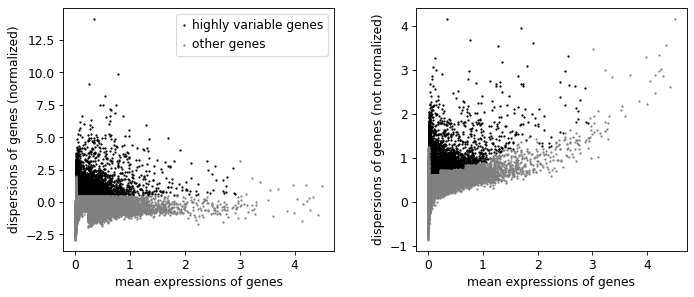

In [256]:
# highly-variable genes are selected
sc.pp.highly_variable_genes(adata, layer=None, n_top_genes=None, min_disp=0.5, min_mean=0.0125,
                                max_mean=3, span=0.3, n_bins=20, flavor='seurat', 
                                subset=False, inplace=True,batch_key=None, check_values=True)
sc.pl.highly_variable_genes(adata)

## Regress out (mostly) unwanted sources of variation.

In [257]:
# Score all genes using our S and G2M phase gene lists
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


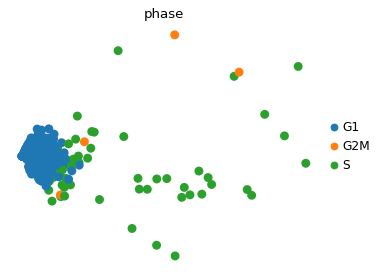

In [258]:
# We will plot the PCA of the cell cycle genes' source of variation
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color= 'phase')

In [259]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var['rp'] = adata.var_names.str.startswith('RP')  # annotate the group of ribosomal genes as 'rp'
sc.pp.calculate_qc_metrics(adata, qc_vars=['rp'], percent_top=None, log1p=False, inplace=True)

... storing 'phase' as categorical


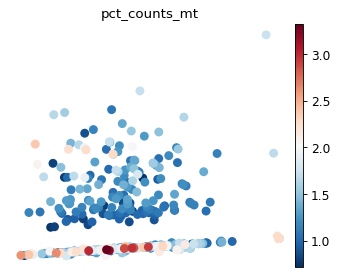

In [260]:
# We will plot the PCA of the mitochondrial genes' source of variation
adata_mt_genes = adata[:, adata.var_names.str.startswith('MT-')]
sc.tl.pca(adata_mt_genes)
sc.pl.pca_scatter(adata_mt_genes, color='pct_counts_mt')

... storing 'phase' as categorical


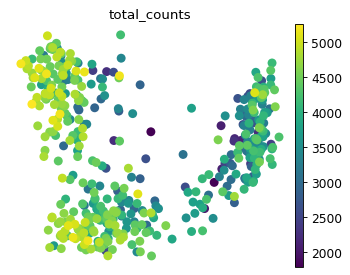

In [261]:
# We will plot the PCA of the total counts' source of variation
adata_hvg = adata[:, adata.var['highly_variable']]
sc.tl.pca(adata_hvg)
sc.pl.pca_scatter(adata_hvg, color='total_counts', cmap='viridis')

In [262]:
# Regress out the unwanted sources of variation.
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

... storing 'phase' as categorical


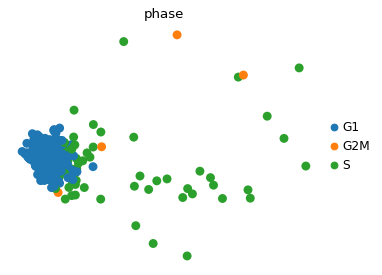

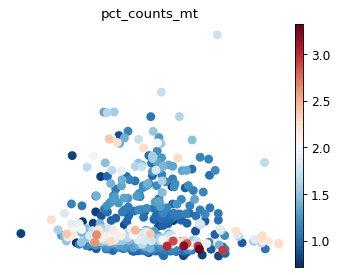

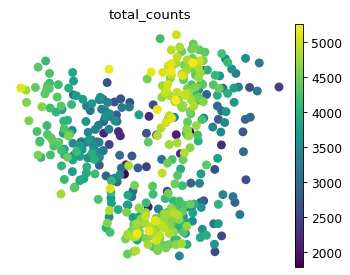

In [263]:
# Plot PCA again after regression
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color= 'phase')
adata_mt_genes = adata[:, adata.var_names.str.startswith('MT-')]
sc.tl.pca(adata_mt_genes)
sc.pl.pca_scatter(adata_mt_genes, color='pct_counts_mt')
adata_hvg = adata[:, adata.var['highly_variable']]
sc.tl.pca(adata_hvg)
sc.pl.pca_scatter(adata_hvg, color='total_counts', cmap='viridis')

## Scaling of the data

In [264]:
# Scale data to unit variance and zero mean store results in layer
# Variables (genes) that do not display any variation (are constant across all observations) 
# are retained and set to 0 during this operation. In the future, they might be set to NaNs.

adata.layers["scaled"] = sc.pp.scale(adata, copy=True).X
adata

AnnData object with n_obs × n_vars = 466 × 19819
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'cluster', 'CELL_TYPE', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp'
    uns: 'log1p', 'hvg'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts', 'scaled'

In [265]:
matrix_summary(adata)

Expression matrix (X): min=-3.6955902576446533, max=5.008607387542725, mean=6.608644621125537e-12
Counts layer matrix (layers['counts']): min=0.0, max=132.0, mean=0.5045523643493652
Raw matrix (raw.X): min=0.0, max=6.2779998779296875, mean=0.20122724771499634
Scaled layer matrix (layers['scaled']): min=-8.748565673828125, max=20.707263946533203, mean=6.490928350366687e-10


## Compute PCA

In [266]:
sc.tl.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

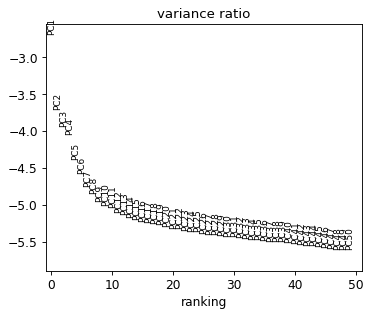

In [267]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

In [268]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=25)
sc.tl.leiden(adata,resolution=0.3)
sc.tl.draw_graph(adata)

In [269]:
# Define a Time point colors
time_colours = ['#F8766D','#7CAE00','#00BFC4','#C77CFF']
# Define a media colors
media_colours = ['#FF7F71','#555555']

In [270]:
custom_order = ['day0','day1','day3','day10']
custom_dtype = pd.CategoricalDtype(categories=custom_order, ordered=True)
adata.obs['Time point'] = adata.obs['Time point'].astype(custom_dtype)
adata.uns['Time point_colors']=time_colours

In [271]:
custom_order = ['NE Expansion','NE Differentiation']
custom_dtype = pd.CategoricalDtype(categories=custom_order, ordered=True)
adata.obs['Media'] = adata.obs['Media'].astype(custom_dtype)
adata.uns['Media_colors']=media_colours

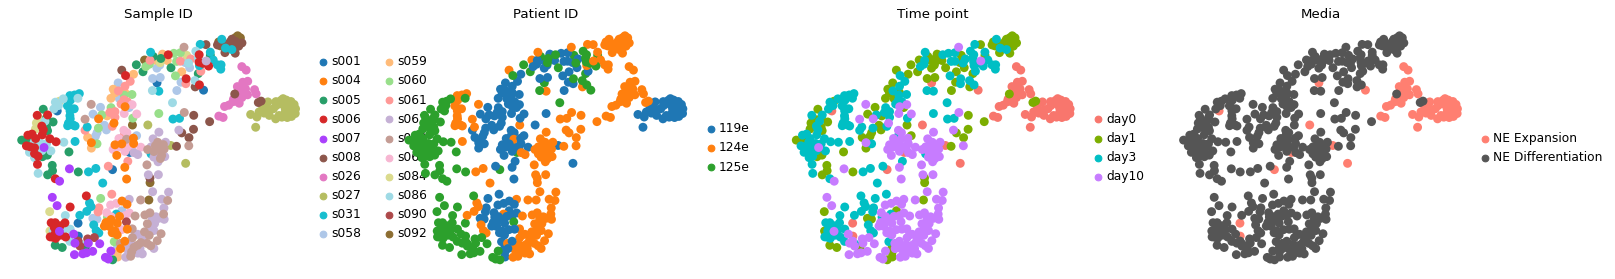

In [272]:
sc.pl.draw_graph(adata, color=['Sample ID','Patient ID','Time point','Media'],save='_Neuroendocrine_NOT_harmonized')

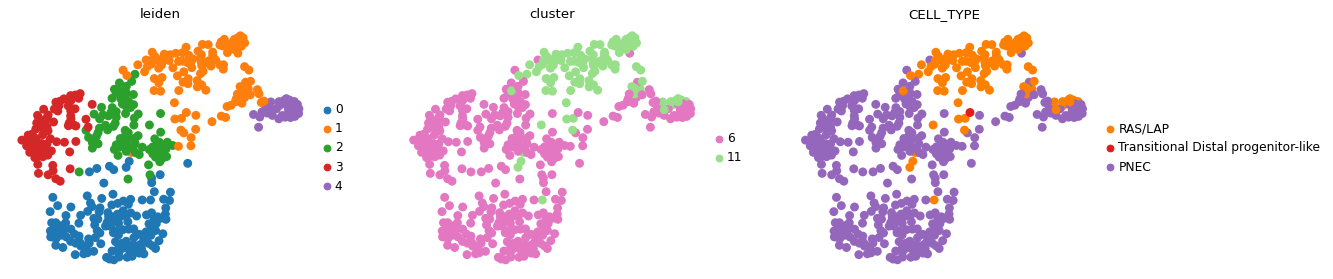

In [273]:
adata.uns['CELL_TYPE_colors']=[
    '#ff7f00',  # RAS/LAP
    '#e41a1c',  # Transitional Distal progenitor-like
    '#9467bd',  # PNEC
]
adata.uns['cluster_colors']=[
    '#e377c2',  # 6
    '#98df8a',  # 11
]
sc.pl.draw_graph(adata, color=['leiden','cluster','CELL_TYPE'])

In [274]:
adata.write_h5ad('./data/Neuroendocrine.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

# Harmony Integration

In [275]:
adata=sc.read_h5ad('./data/Neuroendocrine.h5ad')
adata

AnnData object with n_obs × n_vars = 466 × 19819
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'cluster', 'CELL_TYPE', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp'
    uns: 'CELL_TYPE_colors', 'Media_colors', 'Patient ID_colors', 'Sample ID_colors', 'Time point_colors', 'cluster_colors', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'scaled', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [276]:
sc.external.pp.harmony_integrate(adata, ['Sample ID'], basis='X_pca', adjusted_basis='X_pca_harmony')

2026-01-08 18:45:02,243 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2026-01-08 18:45:04,228 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2026-01-08 18:45:04,232 - harmonypy - INFO - Iteration 1 of 50
INFO:harmonypy:Iteration 1 of 50
2026-01-08 18:45:05,414 - harmonypy - INFO - Iteration 2 of 50
INFO:harmonypy:Iteration 2 of 50
2026-01-08 18:45:06,515 - harmonypy - INFO - Iteration 3 of 50
INFO:harmonypy:Iteration 3 of 50
2026-01-08 18:45:07,418 - harmonypy - INFO - Iteration 4 of 50
INFO:harmonypy:Iteration 4 of 50
2026-01-08 18:45:08,314 - harmonypy - INFO - Iteration 5 of 50
INFO:harmonypy:Iteration 5 of 50
2026-01-08 18:45:09,014 - harmonypy - INFO - Iteration 6 of 50
INFO:harmonypy:Iteration 6 of 50
2026-01-08 18:45:09,614 - harmonypy - INFO - Iteration 7 of 50
INFO:harmonypy:Iteration 7 of 50
2026-01-08 18:45:10,118 - 

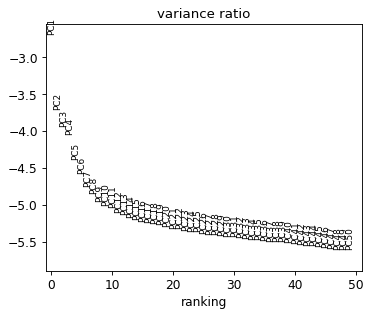

In [277]:
adata.obsm['prev_X_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

In [278]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=25)
sc.tl.leiden(adata,resolution=0.3)
sc.tl.draw_graph(adata)

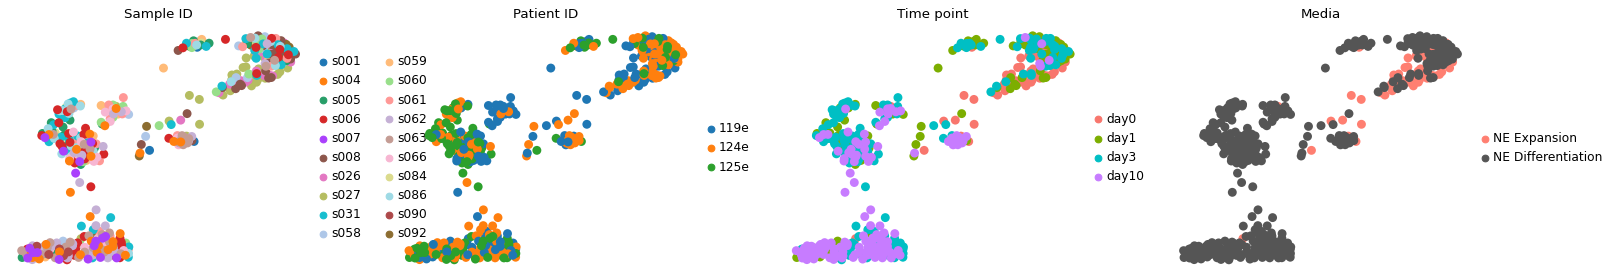

In [279]:
adata.uns['Time point_colors']=time_colours
sc.pl.draw_graph(adata, color=['Sample ID','Patient ID','Time point','Media'], save='_Neuroendocrine_harmonized')

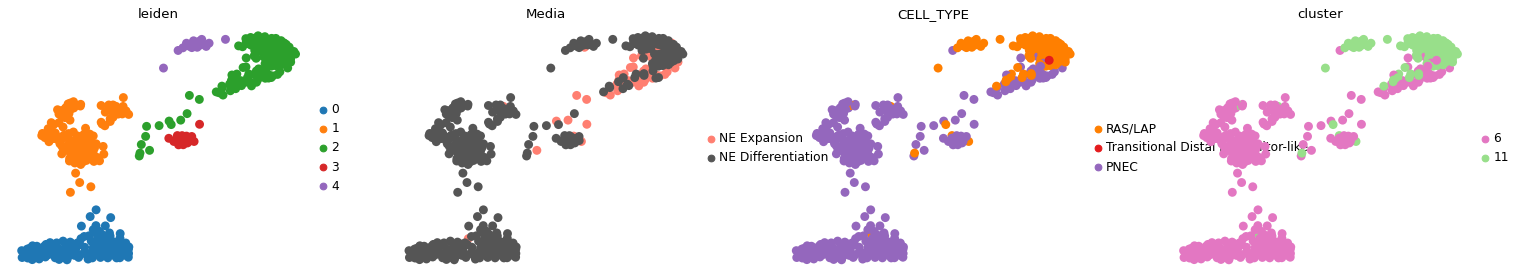

In [280]:
sc.pl.draw_graph(adata, color=['leiden','Media','CELL_TYPE','cluster'])

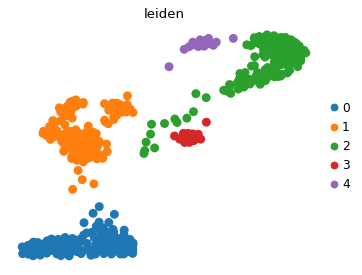

In [281]:
sc.pl.draw_graph(adata, color=['leiden'],save='_Neuroendocrine_leiden')

In [282]:
adata.write_h5ad('./data/Neuroendocrine_annotated.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

# PNEC states Annotation

In [5]:
#Load harmonized adata for annotation
adata=sc.read_h5ad('./data/Neuroendocrine_annotated.h5ad')

In [6]:
#adata.uns['log1p']['base']= None
sc.tl.rank_genes_groups(adata,'leiden',method='wilcoxon', key_added='cluster_markers')

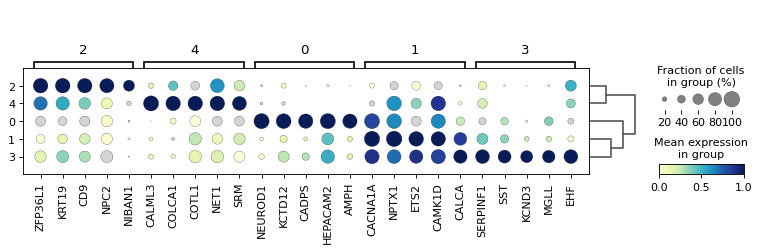

In [7]:
#adata.uns['log1p']['base']= None
sc.tl.filter_rank_genes_groups(adata,key='cluster_markers',
                        key_added='cluster_markers_filtered',
                        min_fold_change=1,min_in_group_fraction=0.5,max_out_group_fraction=0.75)
sc.pl.rank_genes_groups_dotplot(adata,n_genes=5,key='cluster_markers_filtered',cmap=cmap,standard_scale='var',min_logfoldchange=1,vmin=0)

In [8]:
# Define a dictionary to map old cluster names to new cluster names
cluster_name_mapping = {
    '0': 'NEUROD1ʰⁱᵍʰ',
    '1': 'CALCAʰⁱᵍʰ',
    '2': 'NIBAN1ʰⁱᵍʰ',
    '3': 'SSTʰⁱᵍʰ',
    '4': 'CALML3ʰⁱᵍʰ'}
# Use the dictionary to rename clusters in the 'leiden' column of the .obs DataFrame
adata.obs['Cluster'] = adata.obs['leiden'].map(cluster_name_mapping)

In [9]:
adata.obs['Cluster'] = pd.Categorical(adata.obs['Cluster'], 
                                                            categories=['NIBAN1ʰⁱᵍʰ',
                                                                        'CALML3ʰⁱᵍʰ',
                                                                        'SSTʰⁱᵍʰ',
                                                                       'CALCAʰⁱᵍʰ',
                                                                       'NEUROD1ʰⁱᵍʰ'], ordered=True)

In [10]:
adata.uns['Cluster_colors']= ['#e5c494', '#8da0cb', '#a65628', '#8dd3c7', '#984ea3']

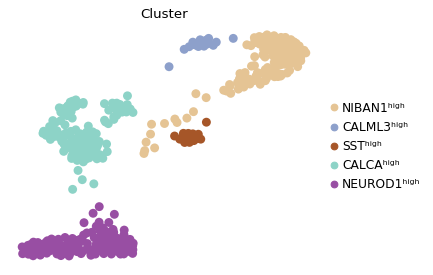

In [11]:
sc.pl.draw_graph(adata,use_raw=True, color=['Cluster'],legend_loc='right margin',save='_Neuroendocrine_subclusters')

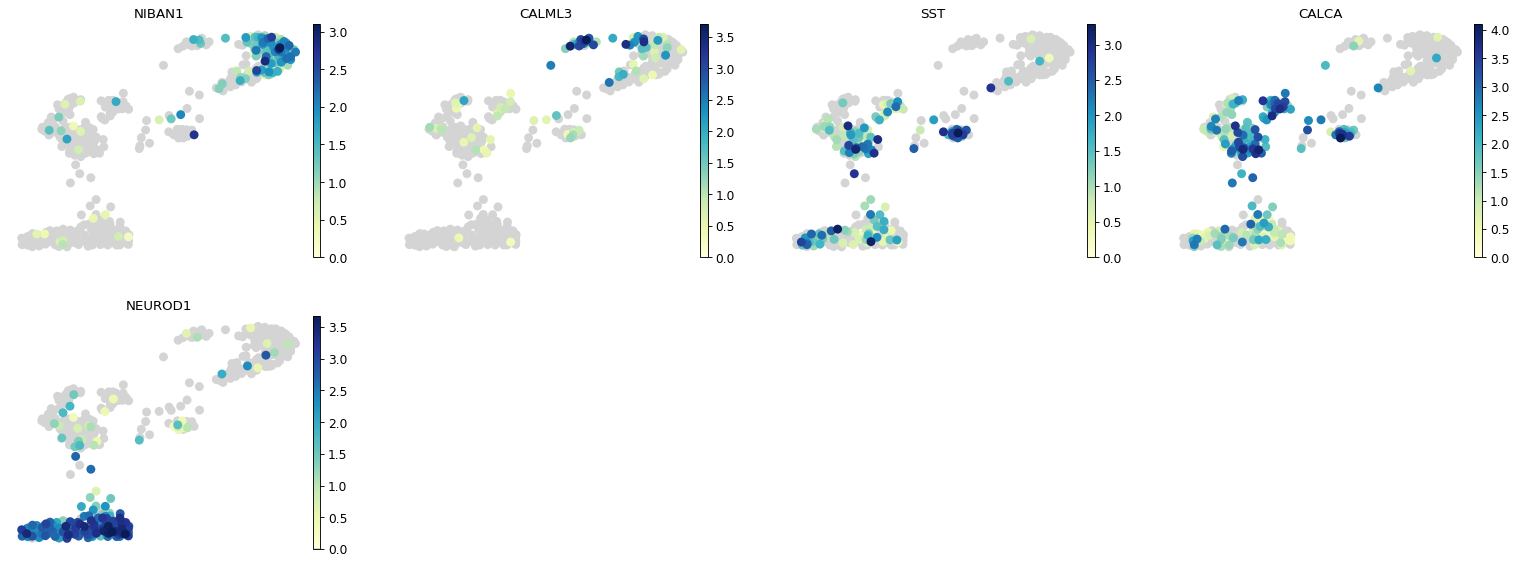

In [12]:
sc.pl.draw_graph(adata,use_raw=True, color=['NIBAN1','CALML3','SST','CALCA','NEUROD1'],
                 legend_loc='right margin',cmap=cmap, vmin=1e-10,save='_Neuroendocrine_subclusters_markers')

In [6]:
#adata.uns['log1p']['base']= None
sc.tl.rank_genes_groups(adata,'Cluster',method='wilcoxon', pts=True, key_added='cluster_markers')

In [8]:
for cluster in adata.obs['Cluster'].unique():
    cluster_DEG = sc.get.rank_genes_groups_df(
        adata,
        group=cluster,
        key='cluster_markers'
    )
    filename = f"./data/markers/PNEC_state_{cluster}_DEG.csv"
    cluster_DEG.to_csv(filename, index=False)

In [10]:
output_file = "./data/markers/PNEC_states_DEG.xlsx"

with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    for cluster in adata.obs['Cluster'].unique():
        cluster_DEG = sc.get.rank_genes_groups_df(
            adata,
            group=cluster,
            key='cluster_markers'
        )
        
        # Excel sheet names must be <= 31 characters
        sheet_name = f"PNEC_state_DEG_{cluster}"[:31]
        cluster_DEG.to_excel(writer, sheet_name=sheet_name, index=False)


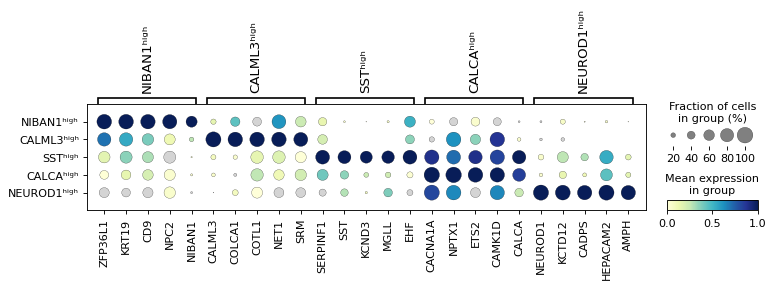

In [18]:
#adata.uns['log1p']['base']= None
sc.tl.filter_rank_genes_groups(adata,key='cluster_markers',
                        key_added='cluster_markers_filtered',
                        min_fold_change=1,min_in_group_fraction=0.5,max_out_group_fraction=0.75)
sc.pl.rank_genes_groups_dotplot(adata,n_genes=5,key='cluster_markers_filtered',
                                dendrogram=False,cmap=cmap,standard_scale='var',min_logfoldchange=1,
                                vmin=0,save='_Neuroendocrine_subclusters_markers')

In [318]:
del adata.uns['cluster_markers_filtered']

adata.write_h5ad('./data/Neuroendocrine_annotated.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

# Cell types contribution

In [6]:
adata=sc.read_h5ad('./data/Neuroendocrine_annotated.h5ad')

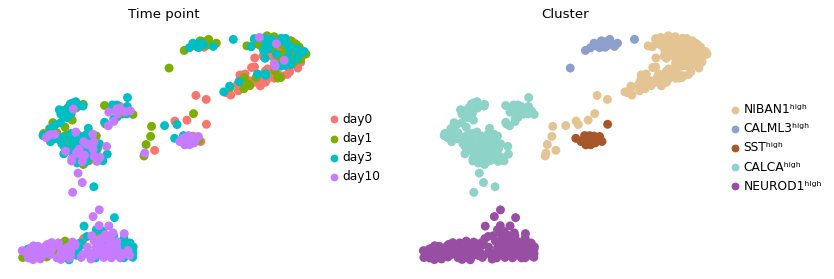

In [7]:
sc.pl.draw_graph(adata, color=['Time point','Cluster'],save='_Neuroendocrine')

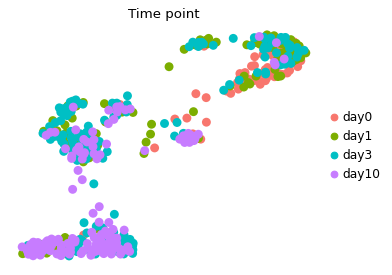

In [8]:
sc.pl.draw_graph(adata,
           color='Time point',
           cmap=cmap, 
           vmin=1e-10,
           use_raw=True,
           frameon=False,
           save='_Neuroendocrine_timepoints')

In [9]:
column_0 = adata.obs['leiden']
column_1 = adata.obs['Cluster']
column_2 = adata.obs['Time point']
column_3 = adata.obs['Media']
column_4 = adata.obs['phase']
column_5 = adata.obs['Patient ID']
column_6 = adata.obs['CELL_TYPE']
# Create a DataFrame using the extracted columns
df = pd.DataFrame({'leiden': column_0,
                   'Cluster': column_1,
                   'Time point': column_2,
                   'Media': column_3,
                   'Phase': column_4,
                  'Patient ID': column_5,
                  'Cell type': column_6})
df

,leiden,Cluster,Time point,Media,Phase,Patient ID,Cell type
s027.5,2,NIBAN1ʰⁱᵍʰ,day0,NE Expansion,S,119e,RAS/LAP
s027.9,2,NIBAN1ʰⁱᵍʰ,day0,NE Expansion,S,119e,PNEC
s027.21,2,NIBAN1ʰⁱᵍʰ,day0,NE Expansion,S,119e,PNEC
s027.29,2,NIBAN1ʰⁱᵍʰ,day0,NE Expansion,S,119e,PNEC
s027.34,2,NIBAN1ʰⁱᵍʰ,day0,NE Expansion,S,119e,PNEC
...,...,...,...,...,...,...,...
s007.127,0,NEUROD1ʰⁱᵍʰ,day10,NE Differentiation,G1,125e,PNEC
s007.128,0,NEUROD1ʰⁱᵍʰ,day10,NE Differentiation,G1,125e,PNEC
s007.130,0,NEUROD1ʰⁱᵍʰ,day10,NE Differentiation,G1,125e,PNEC
s007.140,0,NEUROD1ʰⁱᵍʰ,day10,NE Differentiation,G1,125e,PNEC


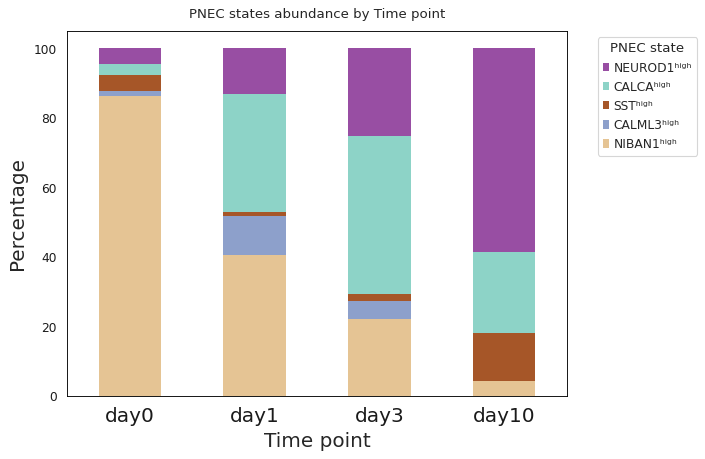

In [96]:
fig, ax = plt.subplots(figsize=(8, 6))

# Group by and calculate the percentage of each category
grouped_df = df.groupby('Time point')['Cluster'].value_counts(normalize=True).unstack(fill_value=0) * 100
grouped_df = grouped_df.reset_index().set_index('Time point')
order = ['day0','day1','day3','day10']
grouped_df = grouped_df.loc[order]

# Plot the bar chart
ax = grouped_df.plot(kind='bar', stacked=True, alpha=1,color=adata.uns['Cluster_colors'],edgecolor='none',ax=ax)

# Customize the plot
plt.title('PNEC states abundance by Time point',pad=12)
plt.xlabel('Time point',size=18, labelpad=6)
plt.ylabel('Percentage', size=18,labelpad=6)
plt.xticks(rotation=0,size=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='PNEC state', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig(os.path.join(figfolder,'StackedPlot_Neuroendocrine_timepoint_celltype'),
            bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

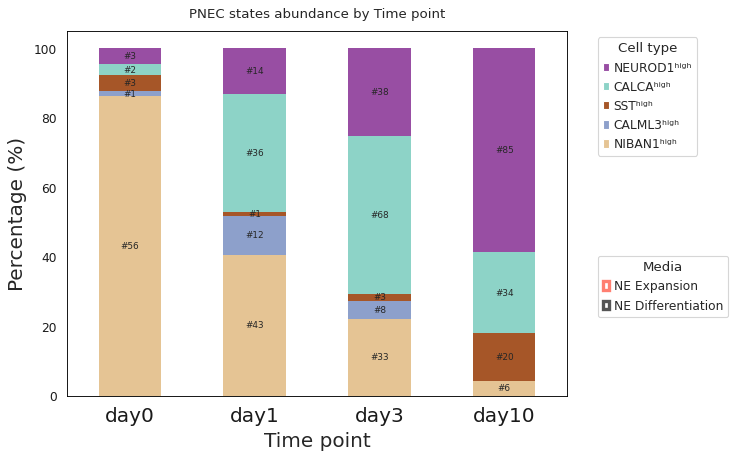

In [97]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(8, 6))

# Group by and calculate the percentage of each category
grouped_df = df.groupby('Time point')['Cluster'].value_counts(normalize=True).unstack(fill_value=0) * 100
grouped_df = grouped_df.reset_index().set_index('Time point')
order = ['day0','day1','day3','day10']
grouped_df = grouped_df.loc[order]

# Plot the bar chart
ax = grouped_df.plot(kind='bar', stacked=True, alpha=1,color=adata.uns['Cluster_colors'],ax=ax)

# Annotate the bars with the counts
i = 0
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    media = order[i % len(order)]
    i += 1
    counts = df.groupby('Time point')['Cluster'].value_counts()
    total_counts = counts.loc[media].sum()
    count = round(height / 100 * total_counts)
    if count == 0:
        continue
    ax.annotate(f'#{count}', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)


# Customize the plot
handles, labels = ax.get_legend_handles_labels()
legend1 = ax.legend(handles[::-1], labels[::-1], title='Cell type', bbox_to_anchor=(1.05, 1))
ax.add_artist(legend1)

ax = grouped_df.sum(axis=1).plot.bar(facecolor='none', edgecolor=['#FF7F71','#555555','#555555','#555555'],linewidth=3,ax=ax)


plt.title('PNEC states abundance by Time point',pad=12)
plt.xlabel('Time point',size=18, labelpad=6)
plt.ylabel('Percentage (%)', size=18,labelpad=6)
plt.xticks(rotation=0,size=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='PNEC state', bbox_to_anchor=(1.05, 1), loc='upper left')

# Create custom legend handles
custom_handles = [
    mpatches.Patch(facecolor='none', edgecolor='#FF7F71',linewidth=3, label='NE Expansion'),
    mpatches.Patch(facecolor='none', edgecolor='#555555',linewidth=3, label='NE Differentiation')
]

# Force each patch to have no edge
for patch in ax.patches:
    patch.set_edgecolor('none')

# Add custom legend
plt.legend(handles=custom_handles, title='Media', bbox_to_anchor=(1.05, 0.4))

plt.savefig(os.path.join(figfolder,'StackedPlot_Neuroendocrine_timepoint_celltype_edges_media'),
            bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

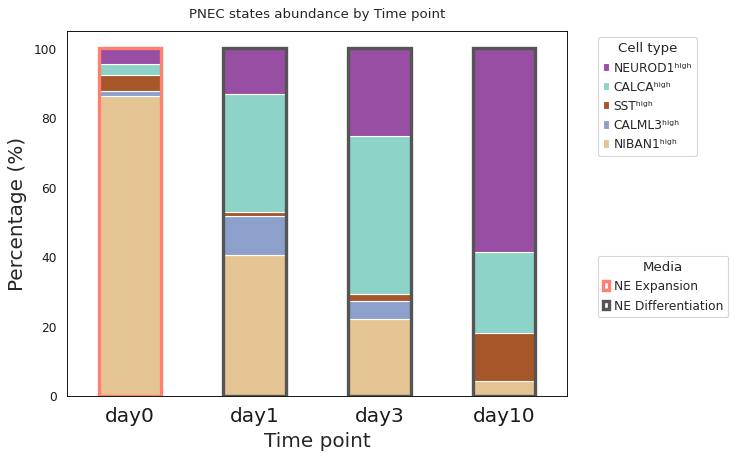

In [114]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(8, 6))

# Group by and calculate the percentage of each category
grouped_df = df.groupby('Time point')['Cluster'].value_counts(normalize=True).unstack(fill_value=0) * 100
grouped_df = grouped_df.reset_index().set_index('Time point')
order = ['day0','day1','day3','day10']
grouped_df = grouped_df.loc[order]

# Plot the bar chart
ax = grouped_df.plot(kind='bar', stacked=True, alpha=1,color=adata.uns['Cluster_colors'],ax=ax)

# Customize the plot
handles, labels = ax.get_legend_handles_labels()
legend1 = ax.legend(handles[::-1], labels[::-1], title='Cell type', bbox_to_anchor=(1.05, 1))
ax.add_artist(legend1)

ax = grouped_df.sum(axis=1).plot.bar(facecolor='none', edgecolor=['#FF7F71','#555555','#555555','#555555'],linewidth=3,ax=ax)

plt.title('PNEC states abundance by Time point',pad=12)
plt.xlabel('Time point',size=18, labelpad=6)
plt.ylabel('Percentage (%)', size=18,labelpad=6)
plt.xticks(rotation=0,size=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='PNEC state', bbox_to_anchor=(1.05, 1), loc='upper left')

# Create custom legend handles
custom_handles = [
    mpatches.Patch(facecolor='none', edgecolor='#FF7F71',linewidth=3, label='NE Expansion'),
    mpatches.Patch(facecolor='none', edgecolor='#555555',linewidth=3, label='NE Differentiation')
]

# Add custom legend
plt.legend(handles=custom_handles, title='Media', bbox_to_anchor=(1.05, 0.4))

plt.savefig(os.path.join(figfolder,'StackedPlot_Neuroendocrine_timepoint_celltype_edges_media'),
            bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

In [12]:
# Group by and calculate the percentage of each category
grouped_df = df.groupby('Time point')['Cluster'].value_counts(normalize=True).unstack(fill_value=0) * 100
grouped_df = grouped_df.reset_index().set_index('Time point')
order = ['day0','day1','day3','day10']
grouped_df = grouped_df.loc[order]
grouped_df

Cluster,NIBAN1ʰⁱᵍʰ,CALML3ʰⁱᵍʰ,SSTʰⁱᵍʰ,CALCAʰⁱᵍʰ,NEUROD1ʰⁱᵍʰ
Time point,,,,,
day0,86.153846,1.538462,4.615385,3.076923,4.615385
day1,40.566038,11.320755,0.943396,33.962264,13.207547
day3,22.000000,5.333333,2.000000,45.333333,25.333333
day10,4.137931,0.000000,13.793103,23.448276,58.620690


In [15]:
grouped_dfs = {}

order = ['day0', 'day1', 'day3', 'day10']

for patient in df['Patient ID'].unique():
    grouped_df = (
        df[df['Patient ID'] == patient]
        .groupby('Time point')['Cluster']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
        * 100
    )

    grouped_df = (
        grouped_df
        .reset_index()
        .set_index('Time point')
        .reindex(order)
    )

    grouped_dfs[patient] = grouped_df

for patient, gdf in grouped_dfs.items():
    print(patient)
    display(gdf)

119e


Cluster,NIBAN1ʰⁱᵍʰ,CALML3ʰⁱᵍʰ,SSTʰⁱᵍʰ,CALCAʰⁱᵍʰ,NEUROD1ʰⁱᵍʰ
Time point,,,,,
day0,89.189189,0.000000,5.405405,2.702703,2.702703
day1,25.000000,13.888889,0.000000,44.444444,16.666667
day3,25.641026,7.692308,2.564103,46.153846,17.948718
day10,2.173913,0.000000,8.695652,39.130435,50.000000


124e


Cluster,NIBAN1ʰⁱᵍʰ,CALML3ʰⁱᵍʰ,SSTʰⁱᵍʰ,CALCAʰⁱᵍʰ,NEUROD1ʰⁱᵍʰ
Time point,,,,,
day0,100.000000,0.000000,0.000000,0.000000,0.000000
day1,85.714286,5.714286,2.857143,0.000000,5.714286
day3,28.571429,4.761905,2.380952,38.095238,26.190476
day10,6.493506,0.000000,20.779221,14.285714,58.441558


125e


Cluster,NIBAN1ʰⁱᵍʰ,CALML3ʰⁱᵍʰ,SSTʰⁱᵍʰ,CALCAʰⁱᵍʰ,NEUROD1ʰⁱᵍʰ
Time point,,,,,
day0,28.571429,14.285714,14.285714,14.285714,28.571429
day1,11.428571,14.285714,0.000000,57.142857,17.142857
day3,15.942029,4.347826,1.449275,49.275362,28.985507
day10,0.000000,0.000000,0.000000,22.727273,77.272727


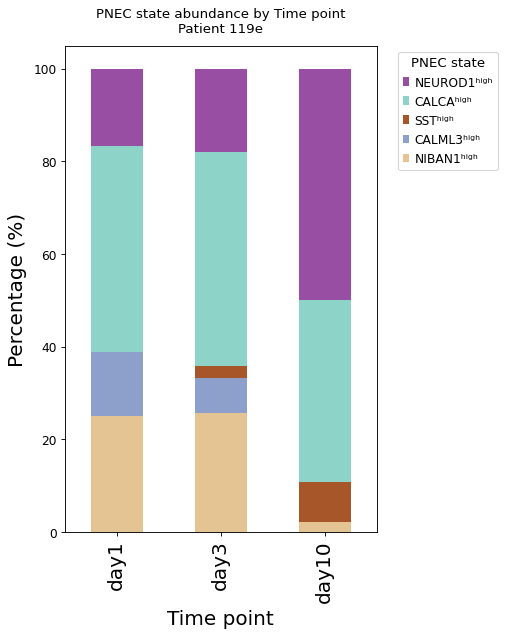

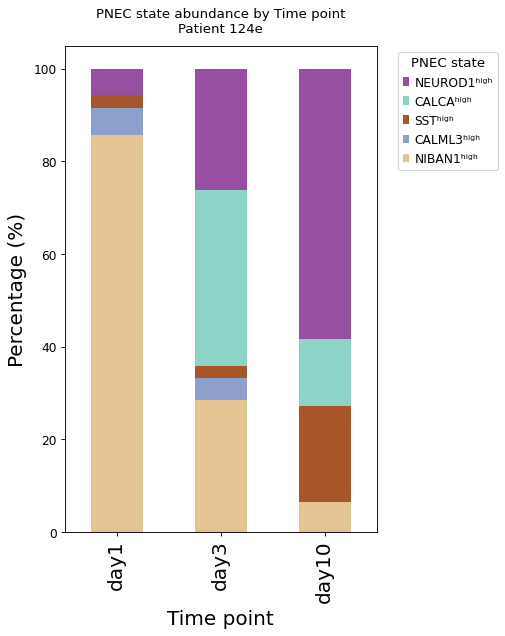

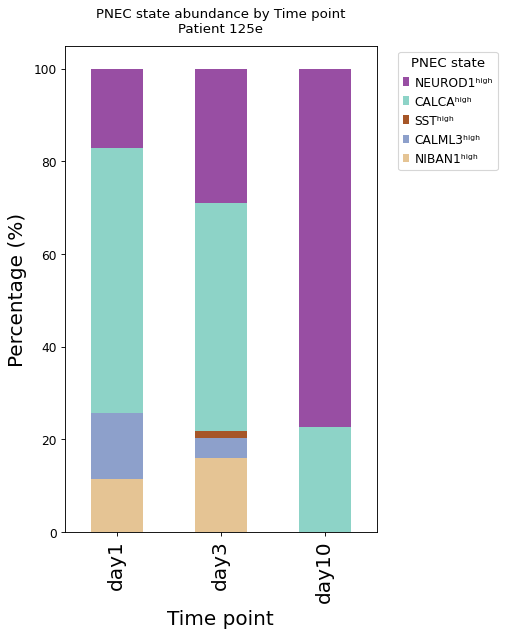

In [18]:
## Figure S5 F

order = ['day1', 'day3', 'day10']

for patient, grouped_df in grouped_dfs.items():

    fig, ax = plt.subplots(figsize=(5, 8))

    # Ensure correct order
    grouped_df = grouped_df.reindex(order)

    # Plot
    grouped_df.plot(
        kind='bar',
        stacked=True,
        alpha=1,
        color=adata.uns['Cluster_colors'],
        ax=ax
    )

    # Customize
    ax.set_title(f'PNEC state abundance by Time point\nPatient {patient}', pad=12)
    ax.set_xlabel('Time point', size=18, labelpad=6)
    ax.set_ylabel('Percentage (%)', size=18, labelpad=6)
    ax.set_xticklabels(
        [label.replace(' ', '\n') for label in grouped_df.index],
        rotation=90,
        size=18
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1],
        labels[::-1],
        title='PNEC state',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )

    # Save figure
    outfile = os.path.join(
        figfolder,
        f'StackedPlot_Neuroendocrine_{patient}_timepoint_PNECstate'
    )
    plt.savefig(outfile, bbox_inches='tight', pad_inches=0.1)

    plt.show()
    plt.close(fig)


In [331]:
adata.write_h5ad('./data/Neuroendocrine.annotated.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

# PNEC state compared to in vivo

In [24]:
adata_PNEC_in_vivo = sc.read_h5ad('./data/Merged_Neuroendocrine_processed.h5ad')
# Create a boolean mask based on your condition
condition_mask = (
    adata_PNEC_in_vivo.obs['Tissue'].isin(['Adult','Fetal'])
)

adata_PNEC_in_vivo = adata_PNEC_in_vivo[condition_mask]
adata_PNEC_in_vivo

View of AnnData object with n_obs × n_vars = 1577 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'in

In [25]:
matrix_summary(adata_PNEC_in_vivo)

Expression matrix (X): min=-6.091112176279742, max=8.199231881195244, mean=-0.00926603074509769
Counts layer matrix (layers['counts']): min=0.0, max=15977.0, mean=0.22093211697880427
Raw matrix (raw.X): min=0.0, max=8.921710102379791, mean=0.09995452845570287
Scaled layer matrix (layers['scaled']): min=-10.97472785456614, max=52.84312625340668, mean=-0.03223102253155334


In [26]:
adata=sc.read_h5ad('./data/Neuroendocrine_annotated.h5ad')
adata.obs['Tissue']='NEr-fAOs'

In [27]:
merged=ad.concat([adata_PNEC_in_vivo, adata],join= 'outer',axis= 0,fill_value= 0)

In [28]:
matrix_summary(merged)

Expression matrix (X): min=-6.091112176279742, max=8.199231881195244, mean=-0.006739692675641992
Counts layer matrix (layers['counts']): min=0.0, max=15977.0, mean=0.24395867400927515
Raw matrix (raw.X): min=0.0, max=8.921710102379791, mean=0.10590948497234771
Scaled layer matrix (layers['scaled']): min=-10.97472785456614, max=52.84312625340668, mean=-0.0234433915082155


In [29]:
merged.X=merged.layers["counts"].copy()

In [30]:
# Normalize counts per cell.
# Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization
sc.pp.normalize_total(merged, target_sum=1e4)

#Logarithmize the data matrix.
#Computes X = log (X=1), where X denotes the natural logarithm unless a different base is given.
sc.pp.log1p(merged)

merged.raw = merged.copy()
merged

AnnData object with n_obs × n_vars = 2043 × 27394
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated

In [31]:
matrix_summary(merged)

Expression matrix (X): min=0.0, max=8.921710102379791, mean=0.10590948495804244
Counts layer matrix (layers['counts']): min=0.0, max=15977.0, mean=0.24395867400927515
Raw matrix (raw.X): min=0.0, max=8.921710102379791, mean=0.10590948495804244
Scaled layer matrix (layers['scaled']): min=-10.97472785456614, max=52.84312625340668, mean=-0.0234433915082155


In [32]:
# Regress out the unwanted sources of variation.
sc.pp.regress_out(merged, ["total_counts", "pct_counts_mt"])

... storing 'Tissue' as categorical
... storing 'Time point' as categorical
... storing 'Media' as categorical
... storing 'CELL_TYPE' as categorical


In [33]:
matrix_summary(merged)

Expression matrix (X): min=-6.118453227058492, max=9.02440569937669, mean=-1.0850648599872421e-16
Counts layer matrix (layers['counts']): min=0.0, max=15977.0, mean=0.24395867400927515
Raw matrix (raw.X): min=0.0, max=8.921710102379791, mean=0.10590948495804244
Scaled layer matrix (layers['scaled']): min=-10.97472785456614, max=52.84312625340668, mean=-0.0234433915082155


In [34]:
# Scale data to unit variance and zero mean store results in layer
# Variables (genes) that do not display any variation (are constant across all observations) 
# are retained and set to 0 during this operation. In the future, they might be set to NaNs.

merged.layers["scaled"] = sc.pp.scale(merged, copy=True).X.copy()
merged

AnnData object with n_obs × n_vars = 2043 × 27394
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated

In [35]:
matrix_summary(merged)

Expression matrix (X): min=-6.118453227058492, max=9.02440569937669, mean=-1.0850648599872421e-16
Counts layer matrix (layers['counts']): min=0.0, max=15977.0, mean=0.24395867400927515
Raw matrix (raw.X): min=0.0, max=8.921710102379791, mean=0.10590948495804244
Scaled layer matrix (layers['scaled']): min=-8.636262691703138, max=45.17738512453988, mean=-9.448047009143674e-17


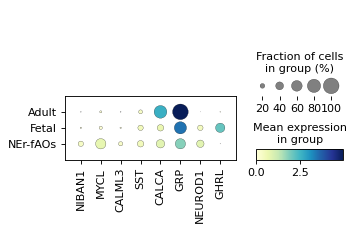

In [36]:
NE_sub_genes = ['NIBAN1','MYCL','CALML3','SST','CALCA','GRP','NEUROD1','GHRL']
sc.pl.dotplot(merged,groupby='Tissue',var_names=NE_sub_genes,cmap=cmap,vmin=0,save='NE_subtype_genes')

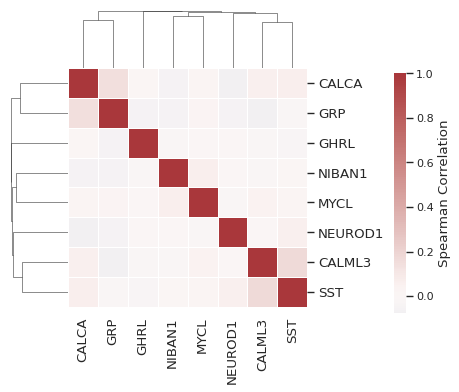

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Define gene list
NE_sub_genes = ['NIBAN1','MYCL','CALML3','SST','CALCA','GRP','NEUROD1','GHRL']

# Extract gene expression from merged.raw
expr_data = merged.raw[:, NE_sub_genes].X
if hasattr(expr_data, "toarray"):  # Convert sparse to dense if needed
    expr_data = expr_data.toarray()

# Create dataframe with gene expression
expr_df = pd.DataFrame(expr_data, columns=NE_sub_genes, index=merged.obs_names)

# Add tissue information
expr_df['Tissue'] = merged.obs['Tissue'].values

# Filter for selected tissues
expr_df = expr_df[expr_df['Tissue'].isin(['Adult'])]

# Drop non-gene columns before computing correlation
gene_expr_only = expr_df[NE_sub_genes]

# Compute correlation matrix
corr_matrix = gene_expr_only.corr(method='spearman')  # or 'pearson'

# Plot clustered heatmap
sns.set(font_scale=1.0)

g = sns.clustermap(
    corr_matrix,
    cmap='vlag',
    center=0,
    linewidths=0.5,
    figsize=(5, 5),
    cbar_kws={'label': 'Spearman Correlation'},
    annot=False,
    row_cluster=True,
    col_cluster=True
)

# Customize heatmap labels
g.ax_heatmap.tick_params(axis='x', rotation=90, labelsize=12)
g.ax_heatmap.tick_params(axis='y', rotation=0, labelsize=12)

# Customize colorbar (RIGHT side, vertical)
g.cax.tick_params(labelsize=10)
g.cax.set_ylabel('Spearman Correlation', size=12)
g.cax.set_position([1, 0.2, 0.03, 0.6])

# Save figure
plt.savefig(
    os.path.join(figfolder, 'NE_all_subtype_gene_Adult_correlation_heatmap_clustered.pdf'),
    dpi=300,
    bbox_inches='tight'
)
plt.show()


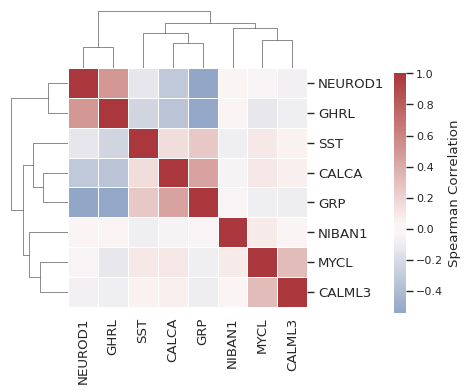

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Define gene list
NE_sub_genes = ['NIBAN1','MYCL','CALML3','SST','CALCA','GRP','NEUROD1','GHRL']
# Extract gene expression from merged.raw
expr_data = merged.raw[:, NE_sub_genes].X
if hasattr(expr_data, "toarray"):  # Convert sparse to dense if needed
    expr_data = expr_data.toarray()

# Create dataframe with gene expression
expr_df = pd.DataFrame(expr_data, columns=NE_sub_genes, index=merged.obs_names)

# Add tissue information
expr_df['Tissue'] = merged.obs['Tissue'].values

# Filter for selected tissues
expr_df = expr_df[expr_df['Tissue'].isin(['Fetal'])]

# Drop non-gene columns before computing correlation
gene_expr_only = expr_df[NE_sub_genes]

# Compute correlation matrix
corr_matrix = gene_expr_only.corr(method='spearman')  # or 'pearson'

# Plot clustered heatmap
sns.set(font_scale=1.0)

g = sns.clustermap(
    corr_matrix,
    cmap='vlag',
    center=0,
    linewidths=0.5,
    figsize=(5, 5),
    cbar_kws={'label': 'Spearman Correlation'},
    annot=False,
    row_cluster=True,
    col_cluster=True
)

# Customize heatmap labels
g.ax_heatmap.tick_params(axis='x', rotation=90, labelsize=12)
g.ax_heatmap.tick_params(axis='y', rotation=0, labelsize=12)

# Customize colorbar (RIGHT side, vertical)
g.cax.tick_params(labelsize=10)
g.cax.set_ylabel('Spearman Correlation', size=12)
g.cax.set_position([1, 0.2, 0.03, 0.6])

# Save figure
plt.savefig(
    os.path.join(figfolder, 'NE_all_subtype_gene_Fetal_correlation_heatmap_clustered.pdf'),
    dpi=300,
    bbox_inches='tight'
)
plt.show()

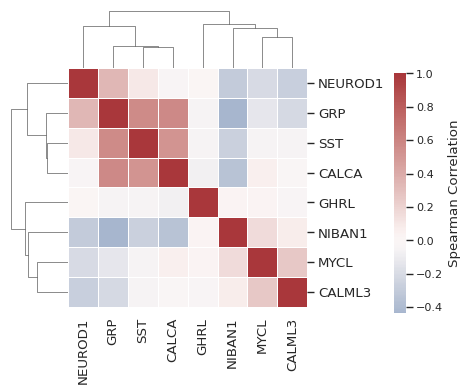

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Define gene list
NE_sub_genes = ['NIBAN1','MYCL','CALML3','SST','CALCA','GRP','NEUROD1','GHRL']
# Extract gene expression from merged.raw
expr_data = merged.raw[:, NE_sub_genes].X
if hasattr(expr_data, "toarray"):  # Convert sparse to dense if needed
    expr_data = expr_data.toarray()

# Create dataframe with gene expression
expr_df = pd.DataFrame(expr_data, columns=NE_sub_genes, index=merged.obs_names)

# Add tissue information
expr_df['Tissue'] = merged.obs['Tissue'].values

# Filter for selected tissues
expr_df = expr_df[expr_df['Tissue'].isin(['NEr-fAOs'])]

# Drop non-gene columns before computing correlation
gene_expr_only = expr_df[NE_sub_genes]

# Compute correlation matrix
corr_matrix = gene_expr_only.corr(method='spearman')  # or 'pearson'
# Plot clustered heatmap
sns.set(font_scale=1.0)

g = sns.clustermap(
    corr_matrix,
    cmap='vlag',
    center=0,
    linewidths=0.5,
    figsize=(5, 5),
    cbar_kws={'label': 'Spearman Correlation'},
    annot=False,
    row_cluster=True,
    col_cluster=True
)

# Customize heatmap labels
g.ax_heatmap.tick_params(axis='x', rotation=90, labelsize=12)
g.ax_heatmap.tick_params(axis='y', rotation=0, labelsize=12)

# Customize colorbar (RIGHT side, vertical)
g.cax.tick_params(labelsize=10)
g.cax.set_ylabel('Spearman Correlation', size=12)
g.cax.set_position([1, 0.2, 0.03, 0.6])

# Save figure
plt.savefig(
    os.path.join(figfolder, 'NE_all_subtype_gene_NEr-fAOs_correlation_heatmap_clustered.pdf'),
    dpi=300,
    bbox_inches='tight'
)
plt.show()


# Velocity

In [5]:
scVelo_adata=sc.read_h5ad('./data/Neuroendocrine_annotated.h5ad')
columns_to_keep = ['Sample ID', 'Media', 'Time point', 'Patient ID', 'n_genes_by_counts', 'total_counts',
                   'total_counts_mt', 'total_counts_rp', 'pct_counts_rp','pct_counts_mt', 'phase',
                   'Cluster','CELL_TYPE', 'leiden','cluster']
columns_to_remove = [column for column in scVelo_adata.obs.columns if column not in columns_to_keep]
scVelo_adata.obs = scVelo_adata.obs.drop(columns=columns_to_remove)
scVelo_adata

AnnData object with n_obs × n_vars = 466 × 19819
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'cluster', 'CELL_TYPE', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'leiden', 'Cluster'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp'
    uns: 'CELL_TYPE_colors', 'Cluster_colors', 'Media_colors', 'Patient ID_colors', 'Sample ID_colors', 'Time point_colors', 'cluster_colors', 'cluster_markers', 'dendrogram_Cluster', 'dendrogram_leiden', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'prev_X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'scaled', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

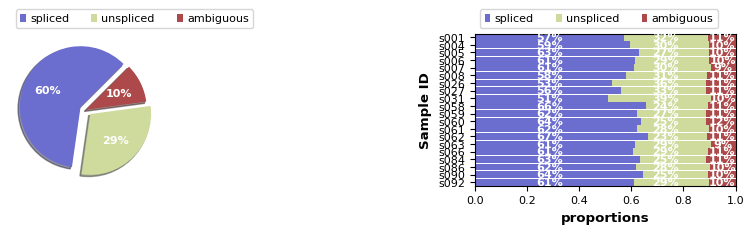

In [6]:
scv.pl.proportions(scVelo_adata,groupby='Sample ID')

In [7]:
scv.pp.moments(scVelo_adata, n_pcs=None, n_neighbors=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [8]:
scv.tl.recover_dynamics(scVelo_adata)

recovering dynamics (using 1/128 cores)


  0%|          | 0/306 [00:00<?, ?gene/s]

    finished (0:01:22) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [9]:
scv.tl.velocity(scVelo_adata, mode="stochastic")

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [10]:
scv.tl.velocity_graph(scVelo_adata)

computing velocity graph (using 1/128 cores)


  0%|          | 0/466 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


figure cannot be saved as pdf, using png instead (can only output finite numbers in pdf).
saving figure to file ./figures/scvelo__draw_graph_fa_Neuroendocrine_Cluster.png


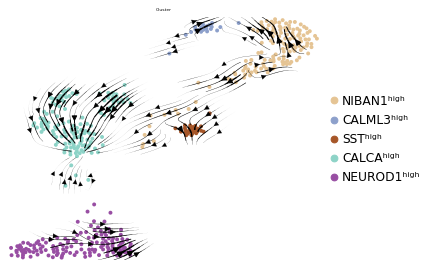

In [16]:
scv.pl.velocity_embedding_stream(scVelo_adata, 
                                basis = 'draw_graph_fa', 
                                color=['Cluster'],
                                 size=50,
                                alpha=1,
                                linecolor='k',
                                linewidth=1,
                                smooth=1, 
                                min_mass=3,
                                frameon=False,
                                colorbar=True,
                                fontsize=4,
                                legend_loc='right margin',
                                save='_draw_graph_fa_Neuroendocrine_Cluster')

figure cannot be saved as pdf, using png instead (can only output finite numbers in pdf).
saving figure to file ./figures/scvelo__draw_graph_fa_Neuroendocrine_timepoint.png


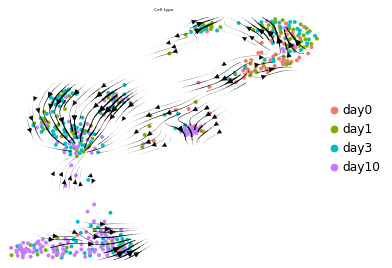

In [15]:
scv.pl.velocity_embedding_stream(scVelo_adata, 
                                basis = 'draw_graph_fa', 
                                color=['Time point'],
                                 size=50,
                                alpha=1,
                                linecolor='k',
                                linewidth=1,
                                smooth=1, 
                                min_mass=3,
                                frameon=False,
                                colorbar=True,
                                title=['Cell type'],
                                fontsize=4,
                                legend_loc='right margin',
                                save='_draw_graph_fa_Neuroendocrine_timepoint')

In [123]:
scVelo_adata.write_h5ad('./data/Neuroendocrine_scVelo.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

# Export Neuroendocrine_annotated

In [354]:
adata_NE=sc.read_h5ad(os.path.join(folder,'Neuroendocrine.annotated.h5ad'))
adata_NE

AnnData object with n_obs × n_vars = 572 × 3826
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'cluster', 'S_score', 'G2M_score', 'phase', 'CELL_TYPE', 'leiden', 'Cluster'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'CELL_TYPE_colors', 'Cluster_colors', 'Media_colors', 'Neuroendocrine_media_condition', 'Neuroendocrine_time_point', 'Patient ID_colors', 'Sample ID_colors', 'Time point_colors', 'cluster_colors', 'cluster_markers', 'dendrogram_Cluster', 'dendrogram_leiden', 'diffmap_evals', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'phase_colors'
    obsm: 'X_diffmap', '

In [355]:
import scipy.sparse as sp
from scipy.io import mmwrite
sparse_matrix = sp.csr_matrix(adata_raw.layers['counts'])
sparse_matrix

<572x21089 sparse matrix of type '<class 'numpy.float32'>'
	with 2295008 stored elements in Compressed Sparse Row format>

In [356]:
mmwrite('AOs_Neuroendocrine_subset.mtx', sparse_matrix)

In [357]:
adata_raw.var

,gene_ids,feature_types,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,rp
ENSG00000238009,ENSG00000238009.6,Gene Expression,3,False,3,0.006993,99.475524,4.0,False
ENSG00000268903,ENSG00000268903.1,Gene Expression,28,False,28,0.054196,95.104895,31.0,False
ENSG00000241860,ENSG00000241860.7,Gene Expression,6,False,6,0.010490,98.951049,6.0,False
ENSG00000228463,ENSG00000228463.10,Gene Expression,24,False,24,0.041958,95.804196,24.0,False
ENSG00000290385,ENSG00000290385.1,Gene Expression,6,False,6,0.012238,98.951049,7.0,False
...,...,...,...,...,...,...,...,...,...
MT-ND6,ENSG00000198695.2,Gene Expression,213,True,213,0.613636,62.762238,351.0,False
MT-TE,ENSG00000210194.1,Gene Expression,12,True,12,0.020979,97.902098,12.0,False
MT-CYB,ENSG00000198727.2,Gene Expression,572,True,572,48.465034,0.000000,27722.0,False
MT-TT,ENSG00000210195.2,Gene Expression,16,True,16,0.027972,97.202797,16.0,False


In [358]:
# Write gene names to csv
var_names = adata_raw.var_names
gene_ids = adata_raw.var['gene_ids']
df = pd.DataFrame({'var_names': var_names, 'gene_ids': gene_ids})
df.to_csv('AOs_Neuroendocrine_subset_gene_names.csv', index=False)

In [359]:
# Write cells names to csv
obs_names = adata_NE.obs_names
df = pd.DataFrame({'obs_names': obs_names})
df.to_csv('AOs_Neuroendocrine_subset_obs_names.csv', index=False)

In [360]:
adata_NE.obsm['X_draw_graph_fa']

array([[ -324.3104968137, -1107.2811457358],
       [ 1659.4230275729,  3453.6577128975],
       [ 1988.8451016794,  3494.2160529061],
       ...,
       [-1941.9527392206, -3802.2622956626],
       [-2617.8717772712, -3207.1432020775],
       [-2489.1594107713, -3895.0392031885]])

In [361]:
# Write metadata to csv
df = pd.DataFrame(adata_NE.obs)
df['X_draw_graph_fa_1']= adata_NE.obsm['X_draw_graph_fa'][:, 0]
df['X_draw_graph_fa_2']= adata_NE.obsm['X_draw_graph_fa'][:, 1]
df.to_csv('AOs_Neuroendocrine_subset_metadata.csv', index=False)
df

,Sample ID,Media,Time point,Patient ID,Passage,Gestational Week,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_rp,pct_counts_rp,cluster,S_score,G2M_score,phase,CELL_TYPE,leiden,Cluster,X_draw_graph_fa_1,X_draw_graph_fa_2
s003.272,s003,Standard,day0-std,124e,P4,week_14,3925,10556.0,939.0,8.895415,1416.0,13.414171,8,0.101959,-0.114930,S,Basal,1,Neuroendocrine CALCA+,-324.310497,-1107.281146
s027.3,s027,NE Expansion,day0,119e,P14,week_18,4295,10317.0,560.0,5.427935,962.0,9.324416,8,-0.114822,-0.160335,G1,Lower Airway Progenitor,0,Neuroendocrine NIBAN1+,1659.423028,3453.657713
s027.12,s027,NE Expansion,day0,119e,P14,week_18,4348,10433.0,687.0,6.584875,1191.0,11.415700,8,-0.019774,-0.044758,G1,Basal,0,Neuroendocrine NIBAN1+,1988.845102,3494.216053
s027.19,s027,NE Expansion,day0,119e,P14,week_18,3565,8271.0,762.0,9.212913,1078.0,13.033490,8,0.003058,-0.115851,S,Lower Airway Progenitor,0,Neuroendocrine NIBAN1+,2019.198434,3594.377922
s027.34,s027,NE Expansion,day0,119e,P14,week_18,2743,5253.0,303.0,5.768133,719.0,13.687417,8,0.277685,-0.002270,S,Basal,2,Neuroendocrine NEUROD1+,-1559.931017,-2885.892947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s007.127,s007,NE Differentiation,day10,125e,P7,week_17,1907,3138.0,214.0,6.819631,223.0,7.106438,12,-0.069062,-0.122481,G1,Neuroendocrine,2,Neuroendocrine NEUROD1+,-1627.659320,-2747.694521
s007.128,s007,NE Differentiation,day10,125e,P7,week_17,5077,12736.0,559.0,4.389133,1034.0,8.118719,12,-0.074835,-0.134334,G1,Neuroendocrine,2,Neuroendocrine NEUROD1+,-2557.376885,-3313.106117
s007.130,s007,NE Differentiation,day10,125e,P7,week_17,2359,4063.0,393.0,9.672656,244.0,6.005414,12,-0.047559,-0.131612,G1,Neuroendocrine,2,Neuroendocrine NEUROD1+,-1941.952739,-3802.262296
s007.140,s007,NE Differentiation,day10,125e,P7,week_17,1704,2944.0,315.0,10.699728,328.0,11.141305,12,-0.046182,-0.132282,G1,Neuroendocrine,2,Neuroendocrine NEUROD1+,-2617.871777,-3207.143202
